## Working with Shapes

Here we explore how to visualize information using the cell morphology

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import libcell

cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 


nrn_define_shape: soma first and last 3-d point at same (x,y)


In [16]:
ps = h.Shape()

# ps = h.Shape(False)
# ps.view(-191.578, -172.628, 369.697, 431.069, 106, 253, 483.84, 563.2)

In [17]:
ps.show(0)
# ps.show(1)

1.0

In [18]:
# add patch clamp
ic = h.IClamp(cell.soma(0.5))

In [19]:
ps.point_mark(ic, 3) # 3=blue

0.0

In [20]:

# New location
ic.loc(cell.dends[30](1))
ic.get_segment()

dend2_12111(1)

In [22]:
ps.point_mark_remove()

0.0

In [23]:
# Another shape plot type is useful for inspecting the activity in all components.
ps = h.PlotShape(0)
ps.view(-191.578, -172.628, 369.697, 431.069, 106, 253, 483.84, 563.2)

1.0

In [24]:
# morphology
ps.variable("v")
# Execute the shape plot
# You can run any command in the menu
ps.exec_menu("Shape Plot")

0.0

In [25]:
# Change the scale
ps.scale(-70, 0)

1.0

In [26]:
# run simple simulation
# Relocate the current clamp to soma.
ic.loc(cell.soma(0.5))

ic.delay = 0 
ic.amp = 0.1 # inject 100 pA
ic.dur = 100 # for 100 ms

h.v_init = -75 # initial voltage
h.tstop = ic.dur # 100 # we simulate the moel during current injection

h.init()
h.run()
ps.flush()

# ... nothing seems to happen because the voltage change is so small

1.0

In [27]:
vs = []
# Go through all the sections/segments
for sec in h.allsec():
    for seg in sec.allseg():
        vs.append(seg.v)
# Find the minimum and maximum of the results (of voltages)
vsmin = np.min(vs)
vsmax = np.max(vs)
print(f'min voltage: {vsmin}, max voltage: {vsmax}')
# Small change! that's why we don't see any current change

min voltage: -75.0, max voltage: -67.79725996648476


In [34]:
# Change the scale!
ps.scale(vsmin, vsmax)

1.0

In [35]:
ps.printfile("L23_voltage_1.eps")

1.0

You can plot other variables, too, with a little trick.

In [36]:

vs = []
for sec in h.allsec():
    for seg in sec.allseg():
        seg.v = h.distance(cell.soma(0.5), seg) # set the distance for soma
        vs.append(seg.v)
        
vsmin = np.min(vs)
vsmax = np.max(vs)
print(f'min voltage: {vsmin}, max voltage: {vsmax}')

ps.scale(vsmin, vsmax)

min voltage: 0.0, max voltage: 1e+20


1.0

# Building a network

Network construction in NEURON follows the following steps:

1. Prepare neurons (morphology, mechanisms, etc.) and external stimuli if necessary,
2. Embed synapse objects in each neuron,
3. Connect the neurons to the synapses via [NetCon](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html),　(instead of simulating the action potentials in the axons)
NetSim is an artificial spike generator.
4. Set up recordings,
5. Run the simulation.

![](./images/net_construction.png)


Here we demonstrate two simple networks with one pyramidal neuron and one or two external stimuli.

## 1 Pyramidal cell + 1 synapse

Again, we start from importing the NEURON and cell module.

In [1]:
# RESTART THE KERNEL
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import libcell

cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 


Here we open a session that embeds a synapse object called [Exp2Syn](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=exp2syn#Exp2Syn).
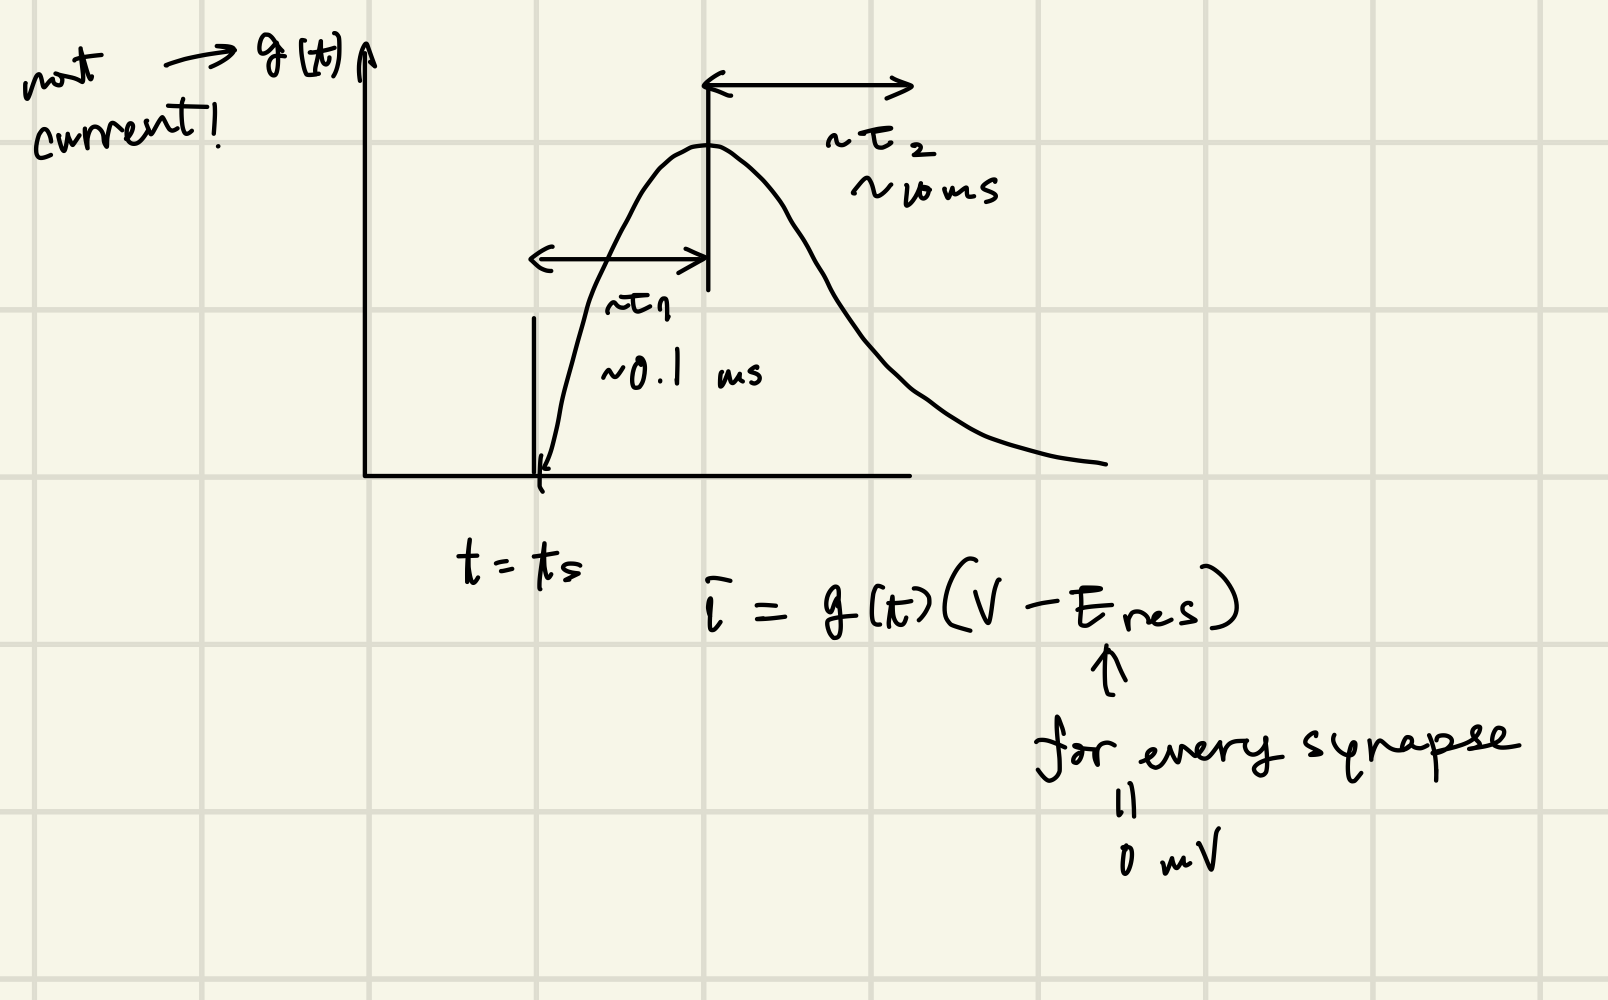

In [2]:
# Particular segment and move these guys around
syn = [h.Exp2Syn(cell.soma(0.5))]

In [3]:
print(f'Erev = {syn[0].e}\ntau1 = {syn[0].tau1} ms\ntau2 = {syn[0].tau2} ms')

Erev = 0.0
tau1 = 0.1 ms
tau2 = 10.0 ms


Again we define our run function:

In [4]:
def run(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    
    trec = h.Vector() # Record time
    vrec = h.Vector() # Record voltage
    
    trec.record(h._ref_t, dt)
    vrec.record(cell.soma(0.5)._ref_v, dt) # record voltage at the center at the soma
    
    h.v_init = -75
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return trec.c(), vrec.c() # Should return a copy of the vector

However, nothing happens during our simulation since there is no input connected to the synapse.

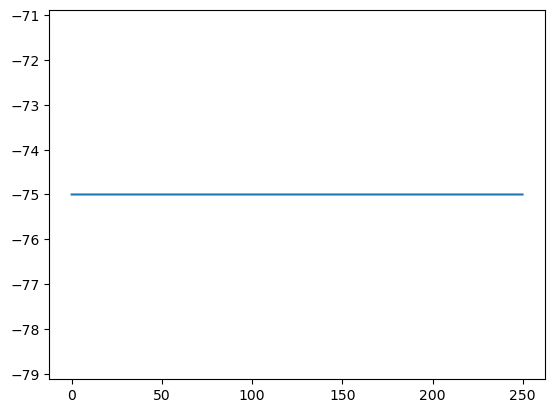

In [5]:
t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)

Therefore, we prepare an artificial spike generator called [NetStim](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=netstim#NetStim) and connect this to this synapse by a `NetCon` object.

In [7]:
# Check out the documentation for what the parameters are
stim = h.NetStim()
stim.start = 50 # 
stim.number = 1 # number of ottal spikes
stim.interval = 5 # interval between spikes
stim.noise = 0 # noise parameter, see what happens

# Connect stim to our synapse
nc = h.NetCon(stim, syn[0]) # connect to 0th synapse

Nothing happens yet since the synaptic conductance is 0. We set this to a non-zero value:

In [11]:
# Set the peak conductance g_peak
nc.weight[0] = 0.01 # 0.01 nS = 10 pS of the synaptic conductance
# Where's the synapse?
syn[0].get_segment()

soma(0.5)

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

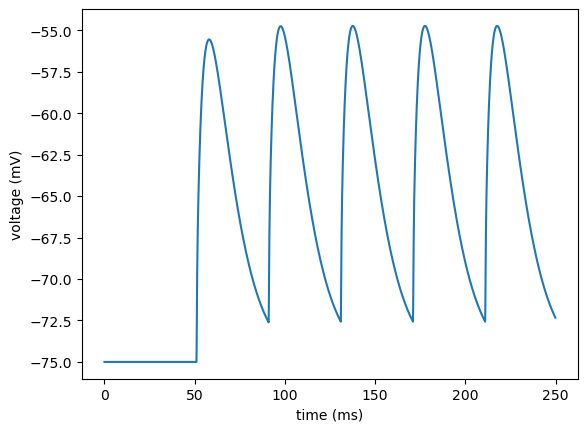

In [13]:
t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

Now we see EPSPs triggered by spikes from `stim`.

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

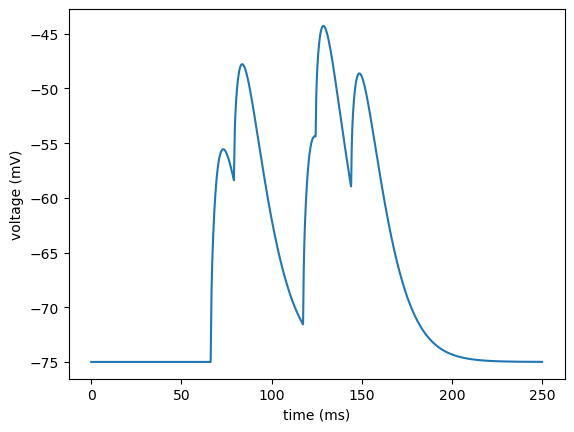

In [20]:
stim.start = 50
stim.number = 5 # number of spikes
stim.interval = 40 # 1000/40 = 25 Hz
stim.noise = 1 # ranges [0, 1]

t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

## Multiple synapses

Of course, we can add more synapses!

In [23]:
syn.append(h.Exp2Syn(cell.soma(0.5)))
print(h.psection())
print(syn)
print(f'Erev = {syn[0].e}\ntau1 = {syn[0].tau1} ms\ntau2 = {syn[0].tau2} ms')
print(f'Erev = {syn[1].e}\ntau1 = {syn[1].tau1} ms\ntau2 = {syn[1].tau2} ms')


soma { nseg=7  L=9.26604  Ra=100
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=29.7838}
	insert pas { g_pas=0.000142857 e_pas=-75}
}
1.0
[Exp2Syn[0], Exp2Syn[1], Exp2Syn[2], Exp2Syn[3]]
Erev = 0.0
tau1 = 0.1 ms
tau2 = 10.0 ms
Erev = 0.0
tau1 = 0.1 ms
tau2 = 10.0 ms


Here we put the spike generators and NetCons in lists:

In [24]:
stim = []
nc = []
for i in range(2):
    stim.append(h.NetStim())
    stim[i].start = 50
    stim[i].number = 1
    stim[i].noise = 0
    
    nc.append(h.NetCon(stim[i], syn[i]))
    nc[i].weight[0] = 0.01

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

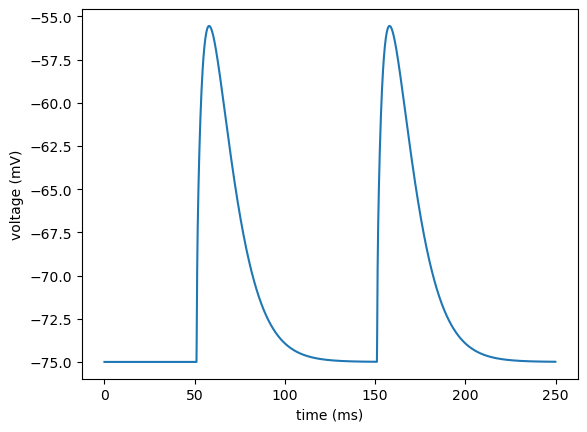

In [26]:
stim[1].start = 150 # starting time of the second stimulus, to be noticeable

t, vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

Here we move the synapses:

In [29]:
syn[0].loc(cell.dends[10](0.2))
syn[1].loc(cell.dends[10](0.8))

0.8

Let's check the locations!

In [30]:
ps = h.Shape(0)
ps.view(-191.578, -172.628, 369.697, 431.069, 106, 253, 483.84, 563.2)

1.0

In [31]:

ps.point_mark(syn[0], 2) # red
ps.point_mark(syn[1], 3) # blue

0.0

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

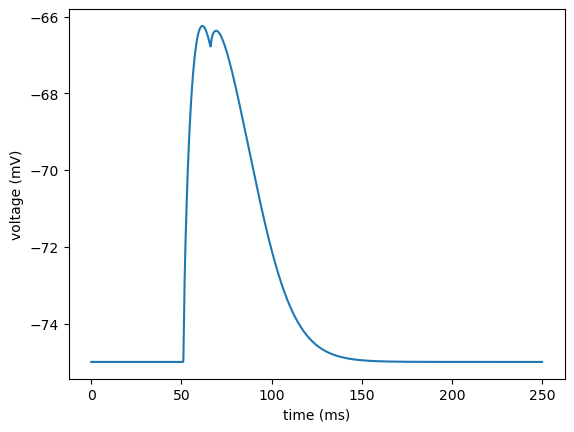

In [32]:
stim[1].start = stim[0].start+15 # 15 miliseconds later than the first spike (red -> blue)

t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

Let's try different locations

In [33]:
syn[0].loc(cell.dends[10](0.25))
syn[1].loc(cell.dends[11](0.8))

0.8

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

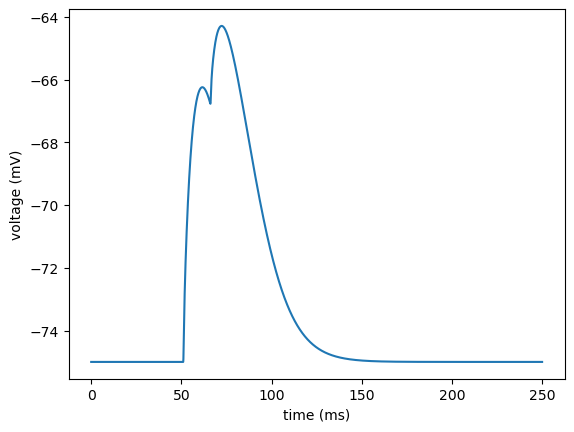

In [34]:
stim[1].start = stim[0].start+15

t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'voltage (mV)')]

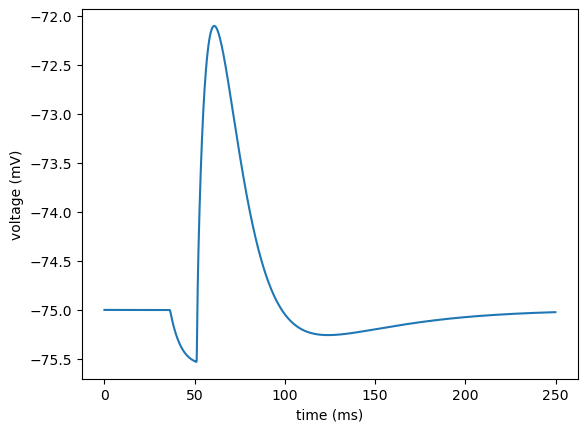

In [41]:
# What if we put the reversal potential lower than the membrane potential?
syn[0].loc(cell.dends[10](0.25))
syn[0].loc(cell.dends[11](0.8))

syn[1].e = -80
syn[1].tau1 = 2
syn[1].tau2 = 40

stim[1].start = stim[0].start-15

t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

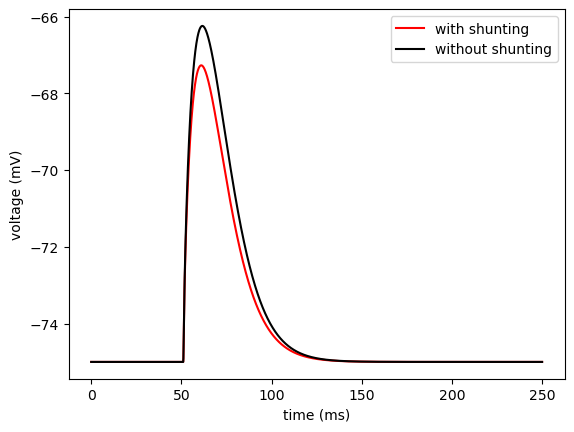

In [49]:
# What about shunting?
# Nothing seems to happen at first
syn[0].loc(cell.dends[10](0.25))
syn[1].loc(cell.dends[10](0.8))

syn[1].e = -75
syn[1].tau1 = 2
syn[1].tau2 = 40

stim[1].start = 0 # stim[0].start-15

nc[1].weight[0] = 0.01
t, vrec = run()

fig, ax = plt.subplots()
ax.plot(t, vrec, 'r', label='with shunting')
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

# Turn off the second synapse
nc[1].weight[0] = 0
t, vrec = run()

ax.plot(t, vrec, 'k', label='without shunting')
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")
plt.legend()